# Following the tutorial here:
https://www.pymc.io/projects/examples/en/latest/case_studies/reinforcement_learning.html 

In [174]:
%load_ext autoreload
%autoreload 2
from rewardgym import get_env, unpack_conditions
from rewardgym.utils import run_single_episode, add_to_df
import pandas as pd
from rewardgym.agents.base_agent import QAgent
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor
import pytensor.tensor as pt
import scipy
from pytensor.printing import Print

from matplotlib.lines import Line2D


def generate_data(envname, alpha=0.25, beta=2.0, n_episodes=100):

    env, conditions = get_env(envname)
    agent = QAgent(learning_rate=alpha, temperature=beta, discount_factor=0.99,
                   action_space=env.action_space.n, state_space=env.n_states)

    avail_actions_list = []

    data = None

    for ne in range(n_episodes):

        condition, starting_position = unpack_conditions(conditions, ne)

        if envname == "risk-sensitive":
            avail_actions = list(env.condition_dict[condition].values())
        else:
            avail_actions = [0, 1]


        a = run_single_episode(env, agent, starting_position, condition, True,
                            avail_actions=avail_actions)

        avail_actions_list.extend([avail_actions for _ in range(len(a[0]))])

        data = add_to_df(a, ne, condition, starting_position, data)

    if envname == "risk-sensitive":
        n_actions = 2
    else:
        n_actions = env.action_space.n

    return data, avail_actions_list, n_actions, env.n_states

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [108]:
def prepare_agent_data(data, avail_actions_list, risk_sensitive=False):

    def mark_last(group):
        result = pd.Series(index=group.index)
        result[group.index[-1]] = 1
        return result

    tmp = pd.DataFrame(data)

    safe_avail_actions = []

    for ii in avail_actions_list:
        if len(ii) == 2:
            safe_avail_actions.append(ii)
        elif len(ii) == 1:
            safe_avail_actions.append(ii + ii)


    if risk_sensitive:
        new_actions = []

        for ii, jj in zip(data['action'], safe_avail_actions):
            new_actions.append(np.argmax(np.array(jj) == ii))

        tmp['action'] = new_actions

    # Apply the function using groupby and transform
    tmp['terminated'] = tmp.groupby('episode').transform(mark_last)['reward']
    tmp['terminated'].fillna(0, inplace=True)

    tmp['avail_actions'] = safe_avail_actions

    tmp['prev_state'] = tmp.groupby('episode')['state'].shift(1)
    tmp.loc[tmp["prev_state"].isnull(), "prev_state"] = tmp.loc[tmp["prev_state"].isnull(), "starting_position"]
    tmp["next_state"] = tmp["state"]

    return tmp

In [163]:
true_alpha = 0.2
true_beta = 2.5

model_out, avail_actions,  n_actions, n_states = generate_data("gonogo", alpha=true_alpha, beta=true_beta)
data = prepare_agent_data(model_out, avail_actions, False)

In [158]:
def update_Q(action, reward, prev_state, next_state, terminated, avail_actions, qs, alpha):

    qs = pt.set_subtensor(qs[prev_state, avail_actions[action]],
                          qs[prev_state, avail_actions[action]] + alpha *
                          (reward - qs[prev_state, avail_actions[action]]))

    return qs


def update_logp(prev_state, avail_actions, qs, logp_actions, beta):

    return pt.set_subtensor(logp_actions[0],
                            qs[prev_state][avail_actions][0] * beta -
                            pt.logsumexp(qs[prev_state][avail_actions] * beta))


def left_action_probs(alpha, beta, prev_states, next_states,
                      actions, rewards, terminated,
                      avail_actions, q_shape): # n_actions, n_states):

    # Compute the qs values
    qs = pt.zeros((q_shape.shape[0], q_shape.shape[1]), dtype="float64")


    qs, _ = pytensor.scan(
        fn=update_Q,
        sequences=[actions, rewards, prev_states, next_states, terminated, avail_actions],
        outputs_info=[qs],
        non_sequences=[alpha]
    )

    logp_actions = pt.zeros((1), dtype='float64')

    logp_actions, _ = pytensor.scan(
        fn=update_logp,
        sequences=[prev_states, avail_actions, qs],
        outputs_info=[logp_actions],
        non_sequences=[beta]
    )

    return logp_actions

In [167]:
with pm.Model() as m_alt:

    qshape = pm.MutableData("qshape", np.zeros((n_states, n_actions)))

    alpha = pm.Beta(name="alpha", alpha=1, beta=1)
    beta = pm.HalfNormal(name="beta", sigma=10)

    prev_states = pm.MutableData('prev_states', data['prev_state'].values.astype(int))
    next_states = pm.MutableData('next_states', data['next_state'].values.astype(int))
    rewards = pm.MutableData('rewards', data['reward'].values)
    actions = pm.MutableData('actions', data['action'].values.astype(int))
    terminated = pm.MutableData('terminated', data['terminated'].values.astype(int))
    avail_actions = pm.MutableData('avail_actions', np.vstack(data['avail_actions'].values).astype(int))

    action_probs = left_action_probs(alpha, beta, prev_states, next_states, actions, rewards, terminated, avail_actions, qshape)
    action_probs = pt.exp(action_probs[1, :])
    like = pm.Bernoulli(name="like", p=action_probs, observed=actions)

In [168]:
with m_alt:
    tr_alt = pm.sample(draws=500, tune=1000, chains=2, cores=4)

Only 5 samples in chain.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [alpha, beta]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 10 tune and 5 draw iterations (20 + 10 draws total) took 12 seconds.
The number of samples is too small to check convergence reliably.


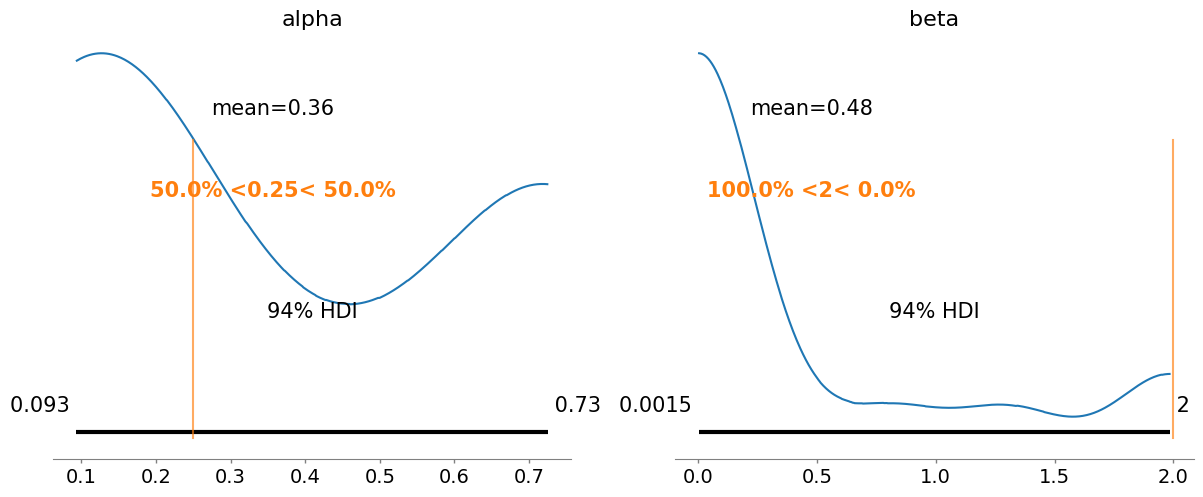

In [172]:

model_out, avail_actions2,  n_actions2, n_states2 = generate_data("risk-sensitive", alpha=true_alpha, beta=true_beta)
data2 = prepare_agent_data(model_out, avail_actions2, True)


with m_alt:
    pm.set_data({"prev_states": data2["prev_state"].values.astype(int),
                 "next_states": data2["next_state"].values.astype(int),
                 "rewards": data2["reward"].values,
                 "actions": data2['action'].values.astype(int),
                 "terminated": data2["terminated"].values.astype(int),
                 "avail_actions": np.vstack(data2['avail_actions'].values).astype(int),
                "qshape": np.zeros((n_states2, n_actions2))})

    tr_alt2 = pm.sample(draws=500, tune=1000, chains=2, cores=5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 5 jobs)
NUTS: [alpha, beta]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


/Users/simons/Seafile/Seafile/RewardMap/rewardGym/.conda/lib/python3.11/site-packages/pytensor/scan/op.py:1576: RuntimeWarning: invalid value encountered in add
  t_fn, n_steps = scan_perform_ext.perform(
Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 116 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [ ]:
az.plot_trace(tr_alt);
az.plot_posterior(data=tr_alt, ref_val=[true_alpha, true_beta]);

NameError: name 'true_alpha' is not defined

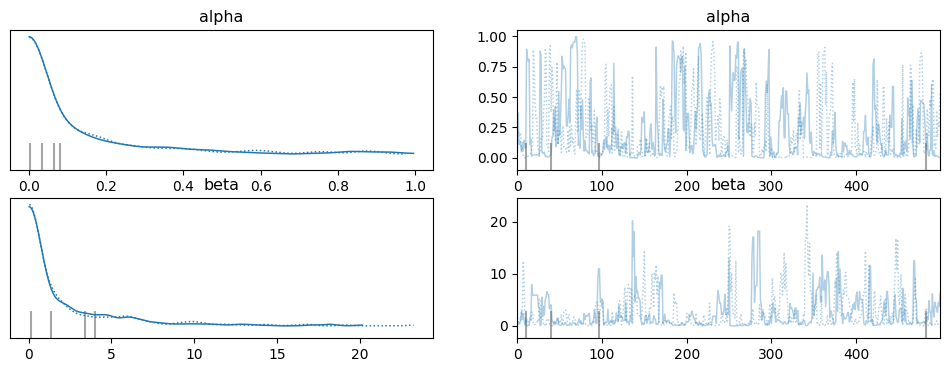

In [175]:
az.plot_trace(tr_alt2);
az.plot_posterior(data=tr_alt2, ref_val=[true_alpha, true_beta]);